In [ ]:
!pip install transformers
!pip install -U catalyst
!pip install pymorphy2
!pip install wordcloud

# 1. Reading data and basic EDA

In [ ]:
# for google colab
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/kontur/test_task')

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import pymorphy2
from typing import Union, List, Dict, Mapping
from tqdm import tqdm

import logging
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoConfig, AutoModel

RANDOM_STATE = 7373

nltk.download('stopwords')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_df = pd.read_table("data/train.tsv") 
test_df = pd.read_table('data/test.tsv')

In [ ]:
lemmatizer = pymorphy2.MorphAnalyzer()

In [ ]:
import re


def clear_text(
        text: str, 
        just_letters: bool = False,
    ) -> str:
    """
    Converts a line to lowercase or delete everything except letters.

    Args:
        text: str - a string to clear

    Returns:
        str
    """

    if just_letters:
        text = re.sub(r'[^А-яЁё]+', ' ', text).lower().replace("ё", "е")
        return ' '.join(text.split())

    text = text.lower().replace("ё", "е")
    return text.strip()
    

def clean_stop_words(
        text: str, 
        stopwords: List[str],
    ) -> str:
    """
    Removes stop words from the string.

    Args:
        text: str - a string to remove stopwords
        stopwords: List[str] - a list with stopwords

    Returns:
        str
    """

    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)


def lemmatize(
        corpus: List[str],
    ) -> List[str]:
    """
    Brings all the words for the texts from the corpus to the original form.

    Args:
        corpus: List[str]

    Returns:
        List[str]
    """

    result = list()

    for text in tqdm(corpus):
        lem_text = list()
        for word in text.split():
            lem_text.append(lemmatizer.parse(word)[0].normal_form)

        result.append(" ".join(lem_text))
        
    return result

In [ ]:
for _ in range(3):

    text = train_df.sample(1)['title'].values[0]
    print(text)
    print('=======================================')
    print(clean_stop_words((clear_text(text)), stop_words))
    print()

Средства инвестфонда потратят как минимум пять компаний
средства инвестфонда потратят минимум пять компаний

Английские консерваторы выступили за сохранение классической бинарной трансгендерности
английские консерваторы выступили сохранение классической бинарной трансгендерности

Победа Леонарда Коэна расстроила поклонников Джастина Бибера
победа леонарда коэна расстроила поклонников джастина бибера



In [ ]:
for _ in range(3):
    text = train_df.sample(1)['title'].to_list()
    print(text)
    text = lemmatize(text)
    print()
    print(text)
    print('=======================================')

['Эвакуированные в Омск афганцы попросили отправить их обратно в Кабул']


100%|██████████| 1/1 [00:00<00:00, 99.07it/s]



['эвакуировать в омск афганец попросить отправить они обратно в кабул']
['Зенит нашел и наказал виновных в нарушении регламента']


100%|██████████| 1/1 [00:00<00:00, 36.79it/s]



['зенит найти и наказать виновный в нарушение регламент']
['В МГУ появится патриотический факультет']


100%|██████████| 1/1 [00:00<00:00, 196.05it/s]


['в мгу появиться патриотический факультет']


In [ ]:
def preproccess_corpus(
        df: Union[pd.Series, pd.DataFrame],
        text_column: Union[str, None] = None,
        stopwords: Union[List[str], None] = None,
        lemmatize: bool = True,
    ) -> pd.Series:
    """
    Full text preprocessing.

    Args:
        df: pd.Series or pd.DataFrame
        text_column: str if pd.DataFrame else None
        stopwords: List[str] if you need to remove stopwords else None
        lemmatize: True if you need lemmatization else False
    Returns:
        pd.Series
    """
    if type(df) == pd.DataFrame:
        df = df[text_column]

    result = list()
    for text in tqdm(df.to_list()):
        text = clear_text(text)
        if stopwords:
            text = clean_stop_words(text, stopwords)
        result.append(text)

    if lemmatize:
        result = lemmatize(result, lemmatizer)
    
    return pd.Series(result, index = df.index)

In [ ]:
train_df['clean_text'] = preproccess_corpus(train_df.title, lemmatize=False, stopwords=None)
test_df['clean_text'] = preproccess_corpus(test_df.title, lemmatize=False, stopwords=None)

100%|██████████| 1000/1000 [00:00<00:00, 114529.63it/s]


In [ ]:
train_df.head()

,title,is_fake,clean_text
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвичу владимиру клутину пришел счет за вмеш...
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорина назвал езду по встречке житейск...
2,Госдума рассмотрит возможность введения секрет...,1,госдума рассмотрит возможность введения секрет...
3,ФАС заблокировала поставку скоростных трамваев...,0,фас заблокировала поставку скоростных трамваев...
4,Против Навального завели дело о недоносительст...,1,против навального завели дело о недоносительст...


In [ ]:
print(train_df.iloc[73]['title'])
print(train_df.iloc[73]['clean_text'])

«Барселона» вышла в четвертьфинал Лиги чемпионов
«барселона» вышла в четвертьфинал лиги чемпионов


### Посмотрим на облака слов в фейковых и правдивых заголовках

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

fake_df = train_df[train_df['is_fake'] == 1]
truth_df = train_df[train_df['is_fake'] == 0]

fake_counter = CountVectorizer(ngram_range=(1, 1))
truth_counter = CountVectorizer(ngram_range=(1, 1))

fake_count = fake_counter.fit_transform(fake_df['clean_text'])
truth_count = truth_counter.fit_transform(truth_df['clean_text'])

fake_frequence = pd.DataFrame(
  {'word' : fake_counter.get_feature_names_out(),
  'frequency' : np.array(fake_count.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

truth_frequence = pd.DataFrame(
    {'word' : truth_counter.get_feature_names_out(),
     'frequency' : np.array(truth_count.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

fake_frequence_filtered = fake_frequence.query("word not in @truth_frequence.word")[:100]
truth_frequence_filtered = truth_frequence.query("word not in @fake_frequence.word")[:100]

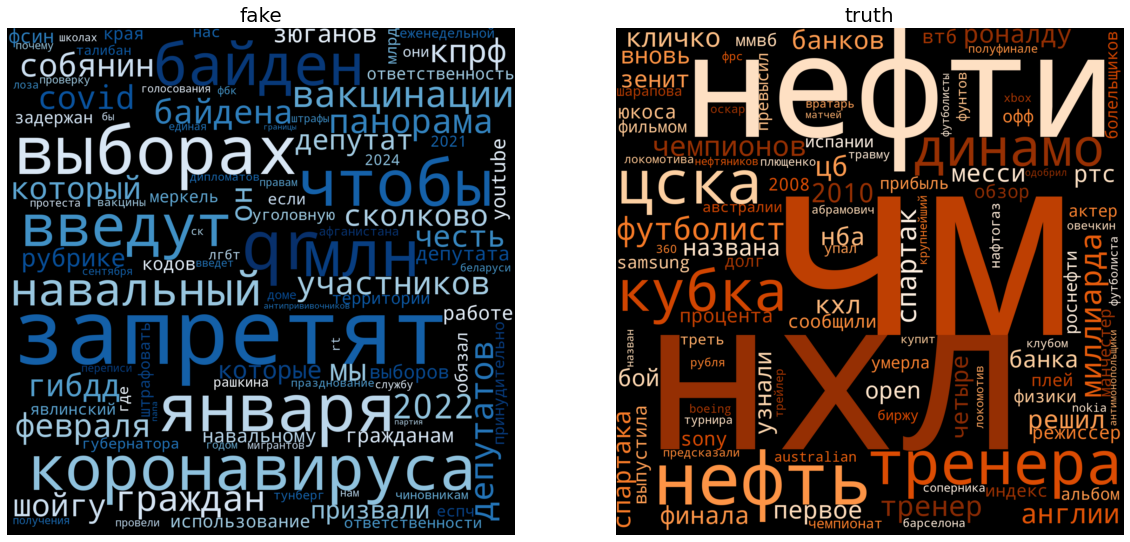

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_fake = WordCloud(background_color="black",
                           colormap = 'Blues',
                           max_words=200,
                           mask=None, 
                           width=1600,
                           height=1600)\
    .generate_from_frequencies(dict(fake_frequence_filtered.values))

wordcloud_truth = WordCloud(background_color="black",
                               colormap = 'Oranges',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
    .generate_from_frequencies(dict(truth_frequence_filtered.values))


fig, ax = plt.subplots(1, 2, figsize = (20, 12))

ax[0].imshow(wordcloud_fake, interpolation='bilinear')
ax[1].imshow(wordcloud_truth, interpolation='bilinear')

ax[0].set_title('fake', fontsize = 20)
ax[1].set_title('truth', fontsize = 20)

ax[0].axis("off")
ax[1].axis("off")

plt.show()

### Разделим данные на тренировочный и валидационный датасеты

In [ ]:
train_df, valid_df = train_test_split(train_df[['clean_text', 'is_fake']], test_size=0.1, random_state=RANDOM_STATE)

print(f"Train size: {len(train_df)}")
print(f"Valid size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

Train size: 5182
Valid size: 576
Test size: 1000


In [ ]:
train_df['is_fake'].value_counts()

0    2606
1    2576
Name: is_fake, dtype: int64

In [ ]:
train_df['clean_text'].apply(
    lambda s: len(s.split())).describe()

count    5182.000000
mean        8.730992
std         2.815672
min         3.000000
25%         7.000000
50%         8.000000
75%        10.000000
max        27.000000
Name: clean_text, dtype: float64

# 2. PyTorch Datasets and DataLoaders

В качестве базовой модели я выбрал Bert для классификации токсичности предложений.

In [ ]:
MODEL_NAME = 'SkolkovoInstitute/russian_toxicity_classifier'

In [ ]:
class TextClassificationDataset(Dataset):
    
    def __init__(
        self,
        texts: List[str],
        labels: List[str] = None,
        max_seq_length: int = 32,
        model_name: str = "SkolkovoInstitute/russian_toxicity_classifier",
    ):
        self.texts = texts
        self.labels = labels
        self.max_seq_length = max_seq_length

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.FATAL)

    def __len__(self) -> int:

        return len(self.texts)
    
    def __getitem__(self, index) -> Mapping[str, torch.Tensor]:

        text = self.texts[index]

        output_dict = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            padding = "max_length",
            max_length = self.max_seq_length,
            return_tensors = "pt",
            truncation = True,
            return_attention_mask = True,
        )

        output_dict["features"] = output_dict["input_ids"].squeeze(0)
        del output_dict["input_ids"]
    
        if self.labels is not None:
            output_dict["targets"] = self.labels[index]
        
        return output_dict

In [ ]:
train_dataset = TextClassificationDataset(
    texts = train_df['clean_text'].to_list(),
    labels = train_df['is_fake'].to_list(),
    max_seq_length=32,
    model_name = MODEL_NAME,
)
valid_dataset = TextClassificationDataset(
    texts = valid_df['clean_text'].to_list(),
    labels = valid_df['is_fake'].to_list(),
    max_seq_length=32,
    model_name = MODEL_NAME,
)
test_dataset = TextClassificationDataset(
    texts = test_df['clean_text'].to_list(),
    labels = test_df['is_fake'].to_list(),
    max_seq_length=32,
    model_name = MODEL_NAME
)

# 3. Model

In [ ]:
class BertForSequenceClassification(nn.Module):

    def __init__(
        self,
        pretrained_model_name: str,
        num_classes: int = None,
        dropout: float = 0.5,
    ):
        super().__init__()

        config = AutoConfig.from_pretrained(
            pretrained_model_name, 
            num_labels = num_classes
        )

        self.model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.fc = nn.Linear(config.hidden_size, config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, features, attention_mask = None, head_mask = None):

        assert attention_mask is not None, "attention mask is none!"

        bert_output = self.model(input_ids=features,
                                 attention_mask=attention_mask,
                                 head_mask=head_mask
                                 )
        
        seq_output = bert_output[0]

        pooled_output = seq_output.mean(axis=1)
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.fc(pooled_output)
        pooled_output = self.dropout(pooled_output)
        scores = self.classifier(pooled_output)

        return scores

# 4. Training

Для упрощения обучения и последующей воспроизводимости результатов я буду использовать библиотеку Catalyst

In [ ]:
import torch
from catalyst.dl import SupervisedRunner
from catalyst.callbacks import (
    AccuracyCallback,
    CheckpointCallback,
    OptimizerCallback,
    PrecisionRecallF1SupportCallback,
)
from catalyst.utils import prepare_cudnn, set_global_seed
from catalyst import utils

In [ ]:
set_global_seed(RANDOM_STATE)
prepare_cudnn(deterministic=True)

In [ ]:
train_val_loaders = {
    "train": DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
    ),
    "valid": DataLoader(
        dataset=valid_dataset,
        batch_size=32,
        shuffle=True,
    ),
}

test_loader = {
    "test": DataLoader(
        dataset=test_dataset,
        batch_size=32,
        shuffle=False,
    )
}

In [ ]:
model = BertForSequenceClassification(MODEL_NAME, num_classes=2, dropout=0.3)

Some weights of the model checkpoint at SkolkovoInstitute/russian_toxicity_classifier were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=3e-5
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2,4], )

In [ ]:
runner = SupervisedRunner(input_key=("features", "attention_mask"))
logdir = '/content/drive/MyDrive/Colab Notebooks/kontur/test_task/logdir/'

In [ ]:
runner.train( 
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=train_val_loaders,
    callbacks=[
               AccuracyCallback(num_classes=2, input_key="features", target_key='targets'),
               OptimizerCallback(metric_key="loss"),
               PrecisionRecallF1SupportCallback(
                   input_key="logits", target_key="targets", num_classes=2,
               ),
    ],
    # logdir=logdir,
    num_epochs=5,
    load_best_on_end=True,
    verbose=True,
)

1/5 * Epoch (train):   0%|          | 0/162 [00:00<?, ?it/s]

train (1/5) accuracy01: 0.04920879969123894 | accuracy01/std: 0.038004170066333776 | f1/_macro: 0.8519802192718774 | f1/_micro: 0.8519826495854989 | f1/_weighted: 0.8519767467034132 | loss: 0.3340510782221025 | loss/mean: 0.3340510782221025 | loss/std: 0.14883043206754504 | lr: 3e-05 | momentum: 0.9 | precision/_macro: 0.8520958405002395 | precision/_micro: 0.8519876495561559 | precision/_weighted: 0.8521409200602743 | recall/_macro: 0.8520396671798954 | recall/_micro: 0.8519876495561559 | recall/_weighted: 0.8519876495561559


1/5 * Epoch (valid):   0%|          | 0/18 [00:00<?, ?it/s]

valid (1/5) accuracy01: 0.0642361111111111 | accuracy01/std: 0.052618626044047226 | f1/_macro: 0.8853439646561847 | f1/_micro: 0.8854116666949018 | f1/_weighted: 0.8851988263020132 | loss: 0.2500993692212634 | loss/mean: 0.2500993692212634 | loss/std: 0.09933841402811089 | lr: 3e-05 | momentum: 0.9 | precision/_macro: 0.8920136901209457 | precision/_micro: 0.8854166666666666 | precision/_weighted: 0.8954259436317795 | recall/_macro: 0.8890944039458891 | recall/_micro: 0.8854166666666666 | recall/_weighted: 0.8854166666666666
* Epoch (1/5) lr: 3e-05 | momentum: 0.9


2/5 * Epoch (train):   0%|          | 0/162 [00:00<?, ?it/s]

train (2/5) accuracy01: 0.0492087996912389 | accuracy01/std: 0.04134863629851857 | f1/_macro: 0.9640960470277702 | f1/_micro: 0.9641015226040857 | f1/_weighted: 0.9640986138050784 | loss: 0.10433876550307444 | loss/mean: 0.10433876550307444 | loss/std: 0.08199255873317635 | lr: 3e-05 | momentum: 0.9 | precision/_macro: 0.9642178075006557 | precision/_micro: 0.9641065225781551 | precision/_weighted: 0.9641837406876452 | recall/_macro: 0.9640673338640404 | recall/_micro: 0.9641065225781551 | recall/_weighted: 0.9641065225781551


2/5 * Epoch (valid):   0%|          | 0/18 [00:00<?, ?it/s]

valid (2/5) accuracy01: 0.0642361111111111 | accuracy01/std: 0.04717246597215074 | f1/_macro: 0.8940203841728738 | f1/_micro: 0.8940922222501831 | f1/_weighted: 0.8938766469423591 | loss: 0.24383036295572916 | loss/mean: 0.24383036295572916 | loss/std: 0.13624584417111152 | lr: 3e-05 | momentum: 0.9 | precision/_macro: 0.9011627906976745 | precision/_micro: 0.8940972222222222 | precision/_weighted: 0.9046955749354004 | recall/_macro: 0.8978892394733979 | recall/_micro: 0.8940972222222222 | recall/_weighted: 0.8940972222222221
* Epoch (2/5) lr: 3e-06 | momentum: 0.9


3/5 * Epoch (train):   0%|          | 0/162 [00:00<?, ?it/s]

train (3/5) accuracy01: 0.04920879971136783 | accuracy01/std: 0.03942708660816228 | f1/_macro: 0.9955562814283145 | f1/_micro: 0.9955565592686466 | f1/_weighted: 0.9955564847426048 | loss: 0.025004235976736875 | loss/mean: 0.025004235976736875 | loss/std: 0.02460191954794233 | lr: 3e-06 | momentum: 0.9 | precision/_macro: 0.9955824154705959 | precision/_micro: 0.9955615592435353 | precision/_weighted: 0.9955703830319071 | recall/_macro: 0.9955491209964582 | recall/_micro: 0.9955615592435353 | recall/_weighted: 0.9955615592435354


3/5 * Epoch (valid):   0%|          | 0/18 [00:00<?, ?it/s]

valid (3/5) accuracy01: 0.0642361111111111 | accuracy01/std: 0.05157542200107889 | f1/_macro: 0.9373863049198587 | f1/_micro: 0.9374950000266665 | f1/_weighted: 0.9375221744827092 | loss: 0.18997583186460862 | loss/mean: 0.18997583186460862 | loss/std: 0.09378561654668305 | lr: 3e-06 | momentum: 0.9 | precision/_macro: 0.9371130661453242 | precision/_micro: 0.9375 | precision/_weighted: 0.9377579559031171 | recall/_macro: 0.9378740071809378 | recall/_micro: 0.9375 | recall/_weighted: 0.9374999999999999
* Epoch (3/5) lr: 3e-06 | momentum: 0.9


4/5 * Epoch (train):   0%|          | 0/162 [00:00<?, ?it/s]

train (4/5) accuracy01: 0.04920879969123891 | accuracy01/std: 0.0386337957674033 | f1/_macro: 0.9982581567027755 | f1/_micro: 0.9982582188594701 | f1/_weighted: 0.9982582168545957 | loss: 0.010532464273130164 | loss/mean: 0.010532464273130164 | loss/std: 0.015072569952961652 | lr: 3e-06 | momentum: 0.9 | precision/_macro: 0.9982643443157146 | precision/_micro: 0.9982632188344268 | precision/_weighted: 0.9982632891770074 | recall/_macro: 0.9982620433972247 | recall/_micro: 0.9982632188344268 | recall/_weighted: 0.9982632188344269


4/5 * Epoch (valid):   0%|          | 0/18 [00:00<?, ?it/s]

valid (4/5) accuracy01: 0.0642361111111111 | accuracy01/std: 0.04600593324474362 | f1/_macro: 0.9339263968637932 | f1/_micro: 0.9340227778045435 | f1/_weighted: 0.934057826736505 | loss: 0.2054093410778377 | loss/mean: 0.2054093410778377 | loss/std: 0.14102402863035196 | lr: 3e-06 | momentum: 0.9 | precision/_macro: 0.9336510042825261 | precision/_micro: 0.9340277777777778 | precision/_weighted: 0.9344583760580654 | recall/_macro: 0.9345736771479345 | recall/_micro: 0.9340277777777778 | recall/_weighted: 0.9340277777777777
* Epoch (4/5) lr: 3.0000000000000004e-07 | momentum: 0.9


5/5 * Epoch (train):   0%|          | 0/162 [00:00<?, ?it/s]

train (5/5) accuracy01: 0.04920879971136781 | accuracy01/std: 0.03656987298388921 | f1/_macro: 0.9988370960710247 | f1/_micro: 0.9988371459146467 | f1/_weighted: 0.99883714005332 | loss: 0.007099606404249924 | loss/mean: 0.007099606404249924 | loss/std: 0.01148913146786479 | lr: 3.0000000000000004e-07 | momentum: 0.9 | precision/_macro: 0.9988477443497017 | precision/_micro: 0.998842145889618 | precision/_weighted: 0.9988433245127935 | recall/_macro: 0.9988376381784987 | recall/_micro: 0.998842145889618 | recall/_weighted: 0.998842145889618


5/5 * Epoch (valid):   0%|          | 0/18 [00:00<?, ?it/s]

valid (5/5) accuracy01: 0.06423611111111112 | accuracy01/std: 0.044809041961928774 | f1/_macro: 0.9373863049198587 | f1/_micro: 0.9374950000266665 | f1/_weighted: 0.9375221744827092 | loss: 0.20487390463757849 | loss/mean: 0.20487390463757849 | loss/std: 0.14322397290709996 | lr: 3.0000000000000004e-07 | momentum: 0.9 | precision/_macro: 0.9371130661453242 | precision/_micro: 0.9375 | precision/_weighted: 0.9377579559031171 | recall/_macro: 0.9378740071809378 | recall/_micro: 0.9375 | recall/_weighted: 0.9374999999999999
* Epoch (5/5) lr: 3.0000000000000004e-07 | momentum: 0.9


# 5. Evaluation predictions

In [ ]:
model = runner.model

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
pred_labels = []
true_labels = []

for i, batch in tqdm(enumerate(train_val_loaders["valid"])):
    inputs = batch['features'].to(device)
    labels = batch['targets'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    output = model(inputs, attention_mask).argmax(axis=1).cpu()
    pred_labels.append(output)
    true_labels.append(labels.cpu().numpy())

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

from sklearn.metrics import f1_score
print(f"\nf1_score: {f1_score(true_labels, pred_labels)}")
print(classification_report(true_labels, pred_labels))

18it [00:02,  8.21it/s]


f1_score: 0.9400000000000001
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       273
           1       0.95      0.93      0.94       303

    accuracy                           0.94       576
   macro avg       0.94      0.94      0.94       576
weighted avg       0.94      0.94      0.94       576



In [ ]:
torch.save(runner.model, "logdir/best_model.pth")

# 6. Prediction

In [ ]:
# model = BertForSequenceClassification(MODEL_NAME, num_classes=2)
# checkpoint = torch.load("logdir/best_model.pth", map_location=torch.device(device))
model = torch.load("logdir/best_model.pth")
model.to(device)

In [ ]:
pred_labels = []

for i, batch in tqdm(enumerate(test_loader["test"])):
    inputs = batch['features'].to(device)
    # labels = batch['targets'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    output = model(inputs, attention_mask).argmax(axis=1).cpu()
    pred_labels.append(output)

pred_labels = np.concatenate(pred_labels, axis=0)

test_df.is_fake = pred_labels

32it [00:04,  7.47it/s]


In [ ]:
test_df.head()

,title,is_fake,clean_text
0,Роскомнадзор представил реестр сочетаний цвето...,1,роскомнадзор представил реестр сочетаний цвето...
1,Ночью под Минском на президентской горе Белара...,1,ночью под минском на президентской горе белара...
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1,бывший спичрайтер юрия лозы рассказал о трудно...
3,"Сельская церковь, собравшая рекордно низкое ко...",1,"сельская церковь, собравшая рекордно низкое ко..."
4,Акции Google рухнули после объявления о переза...,0,акции google рухнули после объявления о переза...


In [ ]:
test_df.is_fake.value_counts()

0    509
1    491
Name: is_fake, dtype: int64

In [ ]:
test_df[['title','is_fake']].to_csv('predictions.tsv', sep="\t")